In [1]:
import numpy as np
import tensorflow as tf

tf.random.set_seed(6789)
np.random.seed(6789)

In [2]:
import os
import zipfile
import collections
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')

class DataManager:
    def __init__(self, verbose=True, maxlen= 50, random_state=6789):
        self.verbose = verbose
        self.max_sentence_len = 0
        self.str_questions = list()
        self.str_labels = list()
        self.numeral_labels = list()
        self.maxlen = maxlen
        self.numeral_data = list()
        self.random_state = random_state
        self.random = np.random.RandomState(random_state)
        
    @staticmethod
    def maybe_download(dir_name, file_name, url, verbose= True):
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
        if not os.path.exists(os.path.join(dir_name, file_name)):
            urlretrieve(url + file_name, os.path.join(dir_name, file_name))
        if verbose:
            print("Downloaded successfully {}".format(file_name))
    
    def read_data(self, dir_name, file_names):
        for file_name in file_names:
            file_path= os.path.join(dir_name, file_name)
            self.str_questions= list(); self.str_labels= list()
            with open(file_path, "r", encoding="latin-1") as f:
                for row in f:
                    row_str= row.split(":")
                    label, question= row_str[0], row_str[1]
                    question= question.lower()
                    self.str_labels.append(label)
                    self.str_questions.append(question[0:-1])
                    if self.max_sentence_len < len(self.str_questions[-1]):
                        self.max_sentence_len= len(self.str_questions[-1])
         
        # turns labels into numbers
        le= preprocessing.LabelEncoder()
        le.fit(self.str_labels)
        self.numeral_labels = np.array(le.transform(self.str_labels))
        self.str_classes= le.classes_
        self.num_classes= len(self.str_classes)
        if self.verbose:
            print("\nSample questions... \n")
            print(self.str_questions[0:5])
            print("Labels {}\n\n".format(self.str_classes))
    
    def manipulate_data(self):
        tokenizer = tf.keras.preprocessing.text.Tokenizer()
        tokenizer.fit_on_texts(self.str_questions)
        self.numeral_data = tokenizer.texts_to_sequences(self.str_questions)
        self.numeral_data = tf.keras.preprocessing.sequence.pad_sequences(self.numeral_data, padding='post', truncating= 'post', maxlen= self.maxlen)
        self.word2idx = tokenizer.word_index
        self.word2idx = {k:v for k,v in self.word2idx.items()}
        self.idx2word = {v:k for k,v in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)
    
    def train_valid_split(self, train_ratio=0.9):
        idxs = np.random.permutation(np.arange(len(self.str_questions)))
        train_size = int(train_ratio*len(idxs)) +1
        self.train_str_questions, self.valid_str_questions = self.str_questions[0:train_size], self.str_questions[train_size:]
        self.train_numeral_data, self.valid_numeral_data = self.numeral_data[0:train_size], self.numeral_data[train_size:]
        self.train_numeral_labels, self.valid_numeral_labels = self.numeral_labels[0:train_size], self.numeral_labels[train_size:]
        self.tf_train_set = tf.data.Dataset.from_tensor_slices((self.train_numeral_data, self.train_numeral_labels))
        self.tf_valid_set = tf.data.Dataset.from_tensor_slices((self.valid_numeral_data, self.valid_numeral_labels))

In [3]:
print('Loading data...')
DataManager.maybe_download("Data", "train_1000.label", "http://cogcomp.org/Data/QA/QC/")
DataManager.maybe_download("Data", "TREC_10.label", "http://cogcomp.org/Data/QA/QC/")

dm = DataManager(maxlen=100)
dm.read_data("Data/", ["train_1000.label", "TREC_10.label"])   # read data

Loading data...
Downloaded successfully train_1000.label
Downloaded successfully TREC_10.label

Sample questions... 

['dist how far is it from denver to aspen ?', 'city what county is modesto , california in ?', 'desc who was galileo ?', 'def what is an atom ?', 'date when did hawaii become a state ?']
Labels ['ABBR' 'DESC' 'ENTY' 'HUM' 'LOC' 'NUM']




In [4]:
dm.manipulate_data()
dm.train_valid_split(train_ratio=0.8)

## <span style="color:#0b486b">Part 2: Using Word2Vect to transform texts to vectors </span>

In [5]:
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [6]:
word2vect = api.load("glove-wiki-gigaword-100")

In [7]:
def get_word_vector(word, model):
    try:
        vector = model.get_vector(word)#Insert your code here
    except: #word not in the vocabulary
        vector = np.zeros([100])#Insert your code here
    return vector

In [8]:
def get_sentence_vector(sentence, important_score=None, model= None):
    #Insert your code here
    final_vector=np.zeros(100)
    tokens = sentence.split()
    vectors = [get_word_vector(word, model) for word in tokens if word in model]
    if important_score.all==None:
        final_vector = np.asarray(vectors).sum(axis = 0)/len(vecs)
    else:
        important_weight = np.exp(important_score)/np.sum(np.exp(important_score))
        for i in range(len(vectors)):
            final_vector = important_weight[i]*vectors[i]
    
    return final_vector

In [9]:
print("Transform training set to feature vectors...")
X_train= np.zeros([len(dm.train_str_questions),100])#Insert your code here
y_train= np.zeros(len(dm.train_numeral_labels))#Insert your code here
important_score=np.zeros(len(dm.train_str_questions))
important_score[0]=1
index = 0
# set important score
for i in range(len(dm.train_str_questions)-1):
    important_score[i+1]=important_score[i]*(1-0.9)

# transform the string sentence form training data set
for sentence in dm.train_str_questions:
    vector = get_sentence_vector(sentence, important_score=important_score, model= word2vect)
    if len(vector)>0:
        X_train[index] = vector
        index = index + 1 
# transform the numerical label form training data set
index = 0    
for label in dm.train_numeral_labels:
    y_train[index]=label
    index = index + 1 

Transform training set to feature vectors...


In [10]:
print("Transform valid set to feature vectors...")
X_valid = np.zeros([len(dm.valid_str_questions),100])#Insert your code here
y_valid = np.zeros(len(dm.valid_numeral_labels))#Insert your code here

# transform the string sentence form validation data set
index = 0
for line in dm.valid_str_questions:
    vector = get_sentence_vector(line, important_score=important_score, model= word2vect)
    if len(vector)>0:
        X_valid[index]=vector
        index = index + 1 

# transform the numerical label form validation data set
index = 0
for label in dm.valid_numeral_labels:
    y_valid[index]=label
    index = index + 1 

Transform valid set to feature vectors...


In [11]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)#Insert your code here
scaler.fit(X_valid)
X_valid = scaler.transform(X_valid)#Insert your code here

In [12]:
svm = SVC(C=1.0, kernel='rbf',gamma=pow(2,-3)) #Insert your code here
#Insert your code for fitting svm on X_train
svm.fit(X_train,y_train)

SVC(gamma=0.125)

In [13]:
y_valid_pred= svm.predict(X_valid)#Insert your code
accuracy = accuracy_score(y_valid,y_valid_pred)#Insert your code
print(accuracy)

0.29292929292929293


## <span style="color:#0b486b">Part 3: Text CNN for sequence modeling and neural embedding </span>


In [14]:
class TextCNN:
    def __init__(self, embed_size= 128, state_size=16, data_manager=None):
        self.data_manager = data_manager
        self.embed_size = embed_size
        self.state_size = state_size
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.data_manager.vocab_size +1, self.embed_size)(x)
        h1 = tf.keras.layers.Conv1D(filters=self.state_size, padding='same', activation='relu', kernel_size=3)(h)#Insert your code here
        h2 = tf.keras.layers.Conv1D(filters=self.state_size, padding='same', activation='relu', kernel_size=5)(h)#Insert your code here
        h3 = tf.keras.layers.Conv1D(filters=self.state_size, padding='same', activation='relu', kernel_size=7)(h)#Insert your code here
        h1 = tf.keras.layers.GlobalMaxPool1D(data_format='channels_last')(h1)#Insert your code here
        h2 = tf.keras.layers.GlobalMaxPool1D(data_format='channels_last')(h2)#Insert your code here
        h3 = tf.keras.layers.GlobalMaxPool1D(data_format='channels_last')(h3)#Insert your code here
        h =  tf.keras.layers.Concatenate(axis=1)([h1, h2, h3])#Insert your code here
        h = tf.keras.layers.Dense(self.data_manager.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h) 
    
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)


In [15]:
text_cnn = TextCNN(data_manager=dm)
text_cnn.build()
#Insert code here to compile the model
text_cnn.compile_model(optimizer="adam",loss='sparse_categorical_crossentropy',metrics=["accuracy"])
#Insert code here to train the model on 20 epochs
text_cnn.model.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 6s 109ms/step - loss: 1.7450 - accuracy: 0.3965 - val_loss: 1.7266 - val_accuracy: 0.4242
Epoch 2/20
7/7 [==============================] - 0s 12ms/step - loss: 1.6031 - accuracy: 0.5810 - val_loss: 1.6472 - val_accuracy: 0.3939
Epoch 3/20
7/7 [==============================] - 0s 12ms/step - loss: 1.4762 - accuracy: 0.5411 - val_loss: 1.5596 - val_accuracy: 0.3939
Epoch 4/20
7/7 [==============================] - 0s 12ms/step - loss: 1.3451 - accuracy: 0.5711 - val_loss: 1.4568 - val_accuracy: 0.4040
Epoch 5/20
7/7 [==============================] - 0s 11ms/step - loss: 1.2052 - accuracy: 0.6534 - val_loss: 1.3325 - val_accuracy: 0.4747
Epoch 6/20
7/7 [==============================] - ETA: 0s - loss: 1.0545 - accuracy: 0.70 - 0s 11ms/step - loss: 1.0545 - accuracy: 0.7082 - val_loss: 1.1905 - val_accuracy: 0.5455
Epoch 7/20
7/7 [==============================] - 0s 12ms/step - loss: 0.8995 - accuracy: 0.8105 - val_loss: 1.0475 - val_a

## <span style="color:#0b486b">Part 4: RNNs for sequence modeling and neural embedding </span>

In [16]:
class UniRNN:
    def __init__(self, cell_type= 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size +1 
        
    #return the correspoding memory cell
    @staticmethod
    def get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh'):
        if cell_type=='gru':
            return tf.keras.layers.GRU(state_size,return_sequences= return_sequences, activation = activation) #Insert your code here
        elif cell_type== 'lstm':
            return tf.keras.layers.LSTM(state_size,return_sequences= return_sequences, activation = activation) #Insert your code here
        else:
            return tf.keras.layers.RNN(state_size,return_sequences= return_sequences, activation = activation) #Insert your code here
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size,mask_zero=True)(x)#Insert your code here
        #Insert your code here
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            #Insert your code here, you can insert more lines if necessary
            if i != num_layers - 1:
                layer = self.get_layer(state_size=self.state_sizes[i],return_sequences= True)
                h=layer(h)
            else:
                layer = self.get_layer(state_size=self.state_sizes[i])
                h=layer(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
   
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


In [17]:
uni_rnn = UniRNN(cell_type= 'basic_rnn', embed_size= 128, state_sizes= [64, 128],data_manager=dm)#Insert your code here
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 9s 328ms/step - loss: 1.6862 - accuracy: 0.3466 - val_loss: 1.5706 - val_accuracy: 0.3131
Epoch 2/20
7/7 [==============================] - 0s 22ms/step - loss: 1.2025 - accuracy: 0.5337 - val_loss: 1.2092 - val_accuracy: 0.4949
Epoch 3/20
7/7 [==============================] - 0s 18ms/step - loss: 0.8385 - accuracy: 0.6459 - val_loss: 1.0263 - val_accuracy: 0.4949
Epoch 4/20
7/7 [==============================] - 0s 18ms/step - loss: 0.6232 - accuracy: 0.7257 - val_loss: 0.8321 - val_accuracy: 0.6061
Epoch 5/20
7/7 [==============================] - 0s 19ms/step - loss: 0.4715 - accuracy: 0.8429 - val_loss: 0.7663 - val_accuracy: 0.6263
Epoch 6/20
7/7 [==============================] - 0s 18ms/step - loss: 0.3469 - accuracy: 0.9352 - val_loss: 0.7529 - val_accuracy: 0.6970
Epoch 7/20
7/7 [==============================] - 0s 17ms/step - loss: 0.3100 - accuracy: 0.9002 - val_loss: 0.5660 - val_accuracy: 0.7677
Epoch 8/20
7/7 [==========

### GRU

In [18]:
uni_rnn =  UniRNN(cell_type= 'gru', embed_size= 128, state_sizes= [64, 128],data_manager=dm)#Insert your code here
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 8s 337ms/step - loss: 1.7003 - accuracy: 0.3591 - val_loss: 1.5622 - val_accuracy: 0.3232
Epoch 2/20
7/7 [==============================] - 0s 17ms/step - loss: 1.2742 - accuracy: 0.4788 - val_loss: 1.2606 - val_accuracy: 0.4040
Epoch 3/20
7/7 [==============================] - 0s 17ms/step - loss: 0.9173 - accuracy: 0.6135 - val_loss: 1.0830 - val_accuracy: 0.4949
Epoch 4/20
7/7 [==============================] - 0s 18ms/step - loss: 0.6390 - accuracy: 0.7232 - val_loss: 0.8071 - val_accuracy: 0.6465
Epoch 5/20
7/7 [==============================] - 0s 17ms/step - loss: 0.3895 - accuracy: 0.9002 - val_loss: 0.7459 - val_accuracy: 0.7273
Epoch 6/20
7/7 [==============================] - 0s 17ms/step - loss: 0.2422 - accuracy: 0.9401 - val_loss: 0.7636 - val_accuracy: 0.6667
Epoch 7/20
7/7 [==============================] - 0s 18ms/step - loss: 0.1505 - accuracy: 0.9651 - val_loss: 0.5945 - val_accuracy: 0.7879
Epoch 8/20
7/7 [==========

### lstm

In [19]:
uni_rnn =  UniRNN(cell_type= 'lstm', embed_size= 128, state_sizes= [64, 128],data_manager=dm)#Insert your code here
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 8s 329ms/step - loss: 1.6926 - accuracy: 0.3990 - val_loss: 1.5083 - val_accuracy: 0.3434
Epoch 2/20
7/7 [==============================] - 0s 18ms/step - loss: 1.2119 - accuracy: 0.5312 - val_loss: 1.2204 - val_accuracy: 0.4545
Epoch 3/20
7/7 [==============================] - 0s 19ms/step - loss: 0.8712 - accuracy: 0.6484 - val_loss: 1.0609 - val_accuracy: 0.4848
Epoch 4/20
7/7 [==============================] - 0s 18ms/step - loss: 0.6272 - accuracy: 0.7307 - val_loss: 0.8558 - val_accuracy: 0.5859
Epoch 5/20
7/7 [==============================] - 0s 17ms/step - loss: 0.4635 - accuracy: 0.8130 - val_loss: 1.0015 - val_accuracy: 0.6061
Epoch 6/20
7/7 [==============================] - 0s 19ms/step - loss: 0.2798 - accuracy: 0.9426 - val_loss: 0.5496 - val_accuracy: 0.7778
Epoch 7/20
7/7 [==============================] - 0s 18ms/step - loss: 0.1694 - accuracy: 0.9751 - val_loss: 0.5451 - val_accuracy: 0.7879
Epoch 8/20
7/7 [==========

### <span style="color:#0b486b">4.2. Bi-directional RNNs for sequence modeling and neural embedding </span> ###

In [20]:
class BiRNN:
    def __init__(self, cell_type= 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size +1
        
    @staticmethod
    def get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh'):
        if cell_type=='gru':
            #Insert your code here
            layer = tf.keras.layers.GRU(state_size,return_sequences= return_sequences, activation = activation)
            return tf.keras.layers.Bidirectional(layer )
        elif cell_type== 'lstm':
            #Insert your code here
            layer = tf.keras.layers.LSTM(state_size,return_sequences= return_sequences, activation = activation)
            return tf.keras.layers.Bidirectional(layer)
        else:
            #Insert your code here
            layer = tf.keras.layers.RNN(state_size,return_sequences= return_sequences, activation = activation)
            return tf.keras.layers.Bidirectional(layer)
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size,mask_zero=True)(x)#Insert your code here
        num_layers = len(self.state_sizes)#Insert your code here
        for i in range(num_layers):
            #Insert your code here, add more lines if necessary
            if i != num_layers-1:
                layer = self.get_layer(state_size=self.state_sizes[i],return_sequences= True)
                h=layer(h)
            else:
                layer = self.get_layer(state_size=self.state_sizes[i])
                h=layer(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


In [21]:
bi_rnn = BiRNN(cell_type= 'basic_rnn', embed_size= 128, state_sizes= [64, 128],data_manager=dm)#Insert your code here
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 16s 592ms/step - loss: 1.6292 - accuracy: 0.3691 - val_loss: 1.4624 - val_accuracy: 0.3333
Epoch 2/20
7/7 [==============================] - 0s 29ms/step - loss: 1.1124 - accuracy: 0.5810 - val_loss: 1.1109 - val_accuracy: 0.4949
Epoch 3/20
7/7 [==============================] - 0s 29ms/step - loss: 0.6880 - accuracy: 0.7481 - val_loss: 0.8296 - val_accuracy: 0.5960
Epoch 4/20
7/7 [==============================] - 0s 30ms/step - loss: 0.3865 - accuracy: 0.8928 - val_loss: 0.6400 - val_accuracy: 0.8081
Epoch 5/20
7/7 [==============================] - 0s 29ms/step - loss: 0.1739 - accuracy: 0.9751 - val_loss: 0.6605 - val_accuracy: 0.7879
Epoch 6/20
7/7 [==============================] - 0s 28ms/step - loss: 0.1168 - accuracy: 0.9726 - val_loss: 0.7166 - val_accuracy: 0.7778
Epoch 7/20
7/7 [==============================] - 0s 28ms/step - loss: 0.0540 - accuracy: 0.9875 - val_loss: 0.3758 - val_accuracy: 0.8990
Epoch 8/20
7/7 [=========

In [22]:
bi_rnn =BiRNN(cell_type= 'gru', embed_size= 128, state_sizes= [64, 128],data_manager=dm) #Insert your code here
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 16s 627ms/step - loss: 1.6443 - accuracy: 0.4140 - val_loss: 1.5016 - val_accuracy: 0.3939
Epoch 2/20
7/7 [==============================] - 0s 29ms/step - loss: 1.1007 - accuracy: 0.6359 - val_loss: 1.1554 - val_accuracy: 0.4343
Epoch 3/20
7/7 [==============================] - 0s 29ms/step - loss: 0.6657 - accuracy: 0.7980 - val_loss: 0.8972 - val_accuracy: 0.5657
Epoch 4/20
7/7 [==============================] - 0s 29ms/step - loss: 0.3592 - accuracy: 0.9002 - val_loss: 0.7281 - val_accuracy: 0.7172
Epoch 5/20
7/7 [==============================] - 0s 29ms/step - loss: 0.1641 - accuracy: 0.9676 - val_loss: 0.5150 - val_accuracy: 0.8081
Epoch 6/20
7/7 [==============================] - 0s 28ms/step - loss: 0.0727 - accuracy: 0.9825 - val_loss: 0.3848 - val_accuracy: 0.8586
Epoch 7/20
7/7 [==============================] - 0s 28ms/step - loss: 0.0331 - accuracy: 0.9900 - val_loss: 0.3151 - val_accuracy: 0.8990
Epoch 8/20
7/7 [=========

In [23]:
bi_rnn = BiRNN(cell_type= 'lstm', embed_size= 128, state_sizes= [64, 128],data_manager=dm)#Insert your code here
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 15s 636ms/step - loss: 1.6284 - accuracy: 0.4214 - val_loss: 1.3852 - val_accuracy: 0.3939
Epoch 2/20
7/7 [==============================] - 0s 31ms/step - loss: 1.0185 - accuracy: 0.6284 - val_loss: 1.0772 - val_accuracy: 0.4949
Epoch 3/20
7/7 [==============================] - 0s 28ms/step - loss: 0.6390 - accuracy: 0.7606 - val_loss: 0.8869 - val_accuracy: 0.5354
Epoch 4/20
7/7 [==============================] - 0s 29ms/step - loss: 0.3780 - accuracy: 0.9002 - val_loss: 0.9091 - val_accuracy: 0.6768
Epoch 5/20
7/7 [==============================] - 0s 28ms/step - loss: 0.1862 - accuracy: 0.9651 - val_loss: 1.1853 - val_accuracy: 0.6768
Epoch 6/20
7/7 [==============================] - 0s 31ms/step - loss: 0.0925 - accuracy: 0.9825 - val_loss: 0.4176 - val_accuracy: 0.8384
Epoch 7/20
7/7 [==============================] - 0s 28ms/step - loss: 0.0536 - accuracy: 0.9875 - val_loss: 0.4220 - val_accuracy: 0.8485
Epoch 8/20
7/7 [=========

In [36]:
class RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
    
    def build_embedding_matrix(self):
        #Insert your code here
        self.word2vect = api.load(self.embed_model) # load embedding model
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = self.word2vect.get_vector(word) # assign weight for the corresponding word and index
            except KeyError: # word cannot be found
                pass
    
    @staticmethod
    def get_layer(cell_type= 'gru', network_type= 'uni-directional', hidden_size= 128, return_sequences= False,activation = 'tanh'):
        #Insert your code here
        if network_type== 'uni-directional':
            if cell_type=='gru':
                return tf.keras.layers.GRU(hidden_size,return_sequences= return_sequences,activation = activation)
            elif cell_type== 'lstm':
                return tf.keras.layers.LSTM(hidden_size,return_sequences= return_sequences,activation = activation)
            else:
                return tf.keras.layers.SimpleRNN(hidden_size,return_sequences= return_sequences,activation = activation)
        
        if network_type== 'bi-directional':
            if cell_type=='gru':
                layer = tf.keras.layers.GRU(state_size,return_sequences= return_sequences,activation = activation)
                return tf.keras.layers.Bidirectional(layer)
            elif cell_type== 'lstm':
                layer = tf.keras.layers.LSTM(state_size,return_sequences= return_sequences,activation = activation)
                return tf.keras.layers.Bidirectional(layer)
            else:
                layer = tf.keras.layers.RNN(state_size,return_sequences= return_sequences,activation = activation)
                return tf.keras.layers.Bidirectional(layer)
        
    def build(self):
        #Insert your code here
        x = tf.keras.layers.Input(shape=[None])
        if self.run_mode == "scratch":# scratch
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)
        elif self.run_mode == "init-only":# init-only
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size,weights= [self.embed_matrix], trainable= False,mask_zero=True) 
        else: # fine-tuned
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True,weights=[self.embed_matrix])    
        
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size,mask_zero=True)(x)#Insert your code here
        num_layers = len(self.state_sizes)#Insert your code here
        for i in range(num_layers):
            #Insert your code here, add more lines if necessary
            if i != num_layers-1:
                layer = self.get_layer(hidden_size=self.state_sizes[i],return_sequences= True)
                h=layer(h)
            else:
                layer = self.get_layer(hidden_size=self.state_sizes[i])
                h=layer(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


### <span style="color:#0b486b">4.4. RNNs with Attention for Text and Sequence Classification</span> ###

In [25]:
class MyAttention(tf.keras.layers.Layer):
    def __init__(self, output_length= 50):
        super(MyAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(output_length)
        self.W2 = tf.keras.layers.Dense(output_length)
        self.V = tf.keras.layers.Dense(1)
        
    #all_states is the collection of all hidden states and last_state is the last hidden state
    def call(self, all_states, last_state):
        #Insert your code here
        all_states_extend = tf.expand_dims(all_states, axis=1)
        attention_score = self.V(tf.keras.activations.tanh(self.W1(last_state) + self.W2(all_states_extend)))
        attention_weight = tf.nn.softmax(attention_score, axis=1)
        context = tf.reduce_sum(tf.linalg.matmul(tf.transpose(attention_weight, perm=[0,2,1]), last_state), axis=1)
        return context, attention_weight

In [26]:
from tensorflow.python.keras.layers import Concatenate

In [27]:
class Attention_RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
    
    def build_embedding_matrix(self):
        #Insert your code here
        self.word2vect = api.load(self.embed_model) # load embedding model
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = self.word2vect.get_vector(word) # assign weight for the corresponding word and index
            except KeyError: # word cannot be found
                pass
    
    @staticmethod
    def get_layer(cell_type= 'gru', network_type= 'uni-directional', hidden_size= 128, return_sequences= False, activation = 'tanh', return_state=True):
        #Insert your code here
        if network_type== 'uni-directional':
            if cell_type=='gru':
                return tf.keras.layers.GRU(hidden_size,return_sequences= return_sequences,activation = activation, return_state=return_state)
            elif cell_type== 'lstm':
                return tf.keras.layers.LSTM(hidden_size,return_sequences= return_sequences,activation = activation, return_state=return_state)
            else:
                return tf.keras.layers.SimpleRNN(hidden_size,return_sequences= return_sequences,activation = activation, return_state=return_state)
        
        if network_type== 'bi-directional':
            if cell_type=='gru':
                layer = tf.keras.layers.GRU(state_size,return_sequences= return_sequences,activation = activation, return_state=return_state)
                return tf.keras.layers.Bidirectional(layer)
            elif cell_type== 'lstm':
                layer = tf.keras.layers.LSTM(state_size,return_sequences= return_sequences,activation = activation, return_state=return_state)
                return tf.keras.layers.Bidirectional(layer)
            else:
                layer = tf.keras.layers.RNN(state_size,return_sequences= return_sequences,activation = activation, return_state=return_state)
                return tf.keras.layers.Bidirectional(layer)
    
    def build(self):
         #Insert your code here
        x = tf.keras.layers.Input(shape=[None])
        if self.run_mode == "scratch":# scratch
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)
        elif self.run_mode == "init-only":# init-only
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size,weights= [self.embed_matrix], trainable= False,mask_zero=True) 
        else: # fine-tuned
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True,weights=[self.embed_matrix])    
        
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size,mask_zero=True)(x)#Insert your code here
        num_layers = len(self.state_sizes)#Insert your code here
        for i in range(num_layers):
            #Insert your code here, add more lines if necessary
            layer = self.get_layer(hidden_size=self.state_sizes[i],return_sequences= True, return_state=True)
            h=layer(h)
            
        context,attention_weights=MyAttention(50)(h[1],h[0])
        h = Concatenate()([context,h[1]]) 
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       
    
    def summary(self, *args, **kwargs):
        self.model.summary(*args, **kwargs)     


In [28]:
# Attention RNN model here
attention_rnn = Attention_RNN(data_manager=dm, run_mode= 'scratch',cell_type= "simple-rnn", embed_size= 128, state_sizes= [64, 64])
attention_rnn.build()

In [29]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
attention_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
attention_rnn.fit(dm.tf_train_set.batch(64), batch_size=32 ,epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 8s 339ms/step - loss: 1.7373 - accuracy: 0.3641 - val_loss: 1.6367 - val_accuracy: 0.2828
Epoch 2/20
7/7 [==============================] - 0s 20ms/step - loss: 1.4363 - accuracy: 0.4489 - val_loss: 1.3382 - val_accuracy: 0.4141
Epoch 3/20
7/7 [==============================] - 0s 27ms/step - loss: 1.0333 - accuracy: 0.5885 - val_loss: 1.1305 - val_accuracy: 0.4848
Epoch 4/20
7/7 [==============================] - 0s 27ms/step - loss: 0.7536 - accuracy: 0.6683 - val_loss: 0.9917 - val_accuracy: 0.4949
Epoch 5/20
7/7 [==============================] - 0s 26ms/step - loss: 0.5529 - accuracy: 0.7930 - val_loss: 0.9169 - val_accuracy: 0.5859
Epoch 6/20
7/7 [==============================] - 0s 20ms/step - loss: 0.4061 - accuracy: 0.8579 - val_loss: 0.6848 - val_accuracy: 0.6364
Epoch 7/20
7/7 [==============================] - 0s 21ms/step - loss: 0.2761 - accuracy: 0.9327 - val_loss: 0.5966 - val_accuracy: 0.7071
Epoch 8/20
7/7 [==========

### <span style="color:#0b486b">4.5. Investigating the embedding vectors from the embedding matrix</span> ###

In [31]:
def cosine_similarity(u,v):
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

In [32]:
import copy 
def sort_max(list_result = None,k=5):
    t= copy.deepcopy(list_result)
    max_number = []
    max_index = []
    for _ in range(k+1):
        number = max(t)
        index = t.index(number)
        t[index] = 0
        max_number.append(number)
        max_index.append(index)
    t = []
    return max_number,max_index

In [33]:
def find_most_similar(word= None, k=5, model= None):
    try:
        # Insert your code here
        word_vect_list =  model.embed_matrix
        word_vec = model.word2vect.get_vector(word)
        result = []
        for i in  word_vect_list :
            result.append( cosine_similarity(i,word_vec))
        sorted_prob,sorted_index = sort_max(result,k)
        relevant_words = []
        for i in sorted_index[1:]:
            if list(my_best_rnn.word2idx.keys())[i] in word2vect:
                relevant_words.append(list(model.word2idx.keys())[i])
        for i in range(1,k):
            print('word: '+ relevant_words[i] + '        similarity:' + str(sorted_prob[i]))
    except: #word not in the vocabulary
        print("Word is not in the dictionary!")

    return relevant_words

In [37]:
#The run of your best model here
my_best_rnn = RNN(data_manager=dm, run_mode= 'init-fine-tune',cell_type= "lstm", embed_size= 128, state_sizes= [64, 64])
my_best_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
my_best_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
my_best_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
7/7 [==============================] - 7s 287ms/step - loss: 1.7285 - accuracy: 0.3541 - val_loss: 1.6292 - val_accuracy: 0.2626
Epoch 2/20
7/7 [==============================] - 0s 17ms/step - loss: 1.4161 - accuracy: 0.4539 - val_loss: 1.2900 - val_accuracy: 0.4040
Epoch 3/20
7/7 [==============================] - 0s 18ms/step - loss: 1.0392 - accuracy: 0.5736 - val_loss: 1.1180 - val_accuracy: 0.4949
Epoch 4/20
7/7 [==============================] - 0s 17ms/step - loss: 0.8055 - accuracy: 0.6708 - val_loss: 1.0034 - val_accuracy: 0.5152
Epoch 5/20
7/7 [==============================] - 0s 17ms/step - loss: 0.6595 - accuracy: 0.7207 - val_loss: 0.9064 - val_accuracy: 0.5657
Epoch 6/20
7/7 [==============================] - 0s 18ms/step - loss: 0.4916 - accuracy: 0.8130 - val_loss: 0.8122 - val_accuracy: 0.5960
Epoch 7/20
7/7 [==============================] - 0s 16ms/step - loss: 0.3794 - accuracy: 0.8653 - val_loss: 0.7111 - val_accuracy: 0.6364
Epoch 8/20
7/7 [==========

In [38]:
find_most_similar(word='poland', k=10, model= my_best_rnn)

word: sodium        similarity:1.0000000625158034
word: perc        similarity:0.6282327806133579
word: union        similarity:0.6275121311923354
word: poliomyelitis        similarity:0.6134158319607024
word: lyndon        similarity:0.5910070940300681
word: milan        similarity:0.5765769885604871
word: venezuela        similarity:0.5606420614998747
word: phenylalanine        similarity:0.5559694089549403
word: difference        similarity:0.5534725213552724


C:\Users\24653\AppData\Local\Temp/ipykernel_33076/3876430330.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))


['people',
 'sodium',
 'perc',
 'union',
 'poliomyelitis',
 'lyndon',
 'milan',
 'venezuela',
 'phenylalanine',
 'difference']

In [39]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=3, init='pca', n_iter=5000)
def plot3D_with_labels(word= None, model= None, k= 10):
   #Insert yout codeh here
    word_list = find_most_similar(word=word, k=k, model= model)
    word_list.append(word)
    low_dim_embs = tsne.fit_transform([model.word2vect.get_vector(item) for item in word_list if item in word2vect])
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    for i, label in enumerate(word_list):
        if label != word:
            x,y,z =  low_dim_embs[i,:]
            ax.scatter(x, y, z)
            ax.text(x, y, z, label, color='green')
        else:
            x,y,z =  low_dim_embs[i,:]
            ax.scatter(x, y, z)
            ax.text(x, y, z, label, color='red')

    ax.set_xlabel('dim-one')
    ax.set_ylabel('dim-two')
    ax.set_zlabel('dim-three')
    plt.show()

C:\Users\24653\AppData\Local\Temp/ipykernel_33076/3876430330.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))


word: sodium        similarity:1.0000000625158034
word: perc        similarity:0.6282327806133579
word: union        similarity:0.6275121311923354
word: poliomyelitis        similarity:0.6134158319607024
word: lyndon        similarity:0.5910070940300681
word: milan        similarity:0.5765769885604871
word: venezuela        similarity:0.5606420614998747
word: phenylalanine        similarity:0.5559694089549403
word: difference        similarity:0.5534725213552724
word: trivial        similarity:0.5429075278975782
word: bird        similarity:0.5426675054854344
word: wayne        similarity:0.5397791708658602
word: active        similarity:0.5220094702836579
word: another        similarity:0.5202686443120991
word: sport        similarity:0.5161577366101106
word: lights        similarity:0.5033043562171986
word: tunnel        similarity:0.49628328890514767
word: pathogens        similarity:0.48991315386490103
Word is not in the dictionary!


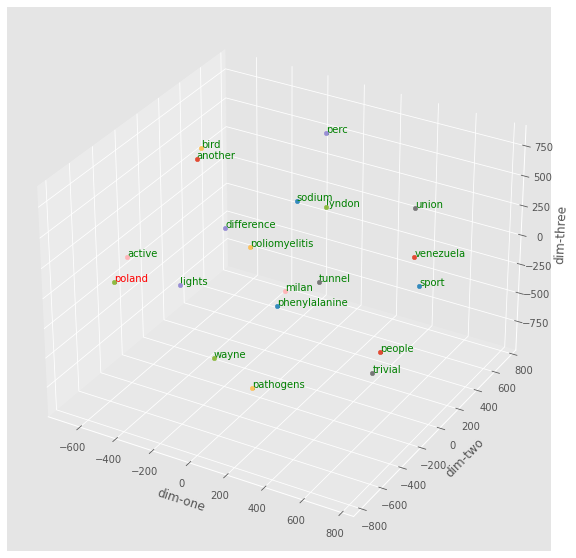

In [40]:
 plot3D_with_labels(word= 'poland', model= my_best_rnn, k= 20)